## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
#BIWI頭部姿勢數據集
#這數據集原本有很多部分不過我們將其簡化，其中有一項是他們在臉部中心標記一個點。所以我們要嘗試創建一個在臉上找到這個點的模型。
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting and converting the data

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
"他們使用了深度攝像機，我猜他們用的是Xbox Kinect。"
"他們在一個文件裡提供了一些測量數據，我們需要讀取出來："
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [ ]:
"""這是一個圖片文件的例子(09/frame_00667_rgb.jpg)。
   臉部中心的坐標是[263.9104, 428.5814](第10行)。只有兩個數字就可以表示臉部中心的位置。
   如果我們要創建一個找到臉部中心的位置的模型，我們需要一個能找出兩個數字的神經網絡，而此數值是位置。
   目前為止，我們做的都是分類模型，用來創建標籤或者類別。這個例子是第一次創建一個回歸模型。
   很多人認為回歸代表線性回歸，不是這樣。回歸代表你的模型的結果是一個或多個連續值。所以我們要創建一個圖像回歸模型。"""

In [5]:
fname = '09/frame_00667_rgb.jpg'

In [6]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

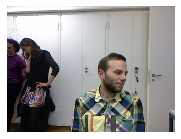

In [7]:
img = open_image(path/fname)
img.show()

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [9]:
"這裡使用一個函數，你要用它把相機坐標轉換成圖片中的坐標。"
"""我們做的不是一個圖片，不是一個對圖片的分割，而是一個圖上的一個點(return ImagePoints....)。
圖片點使用了坐標的概念。它們不是像素值，而是XY坐標 (只有兩個數字)。"""
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [10]:
get_ctr(fname)

tensor([263.9104, 428.5814])

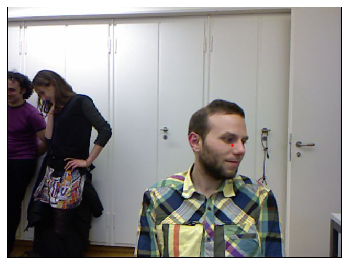

In [11]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [ ]:
"""
1.取一個圖片文件列表（ImageItemList）.它存在一個文件夾裡(path)
2.用某個函數來劃分訓練集和驗證集。這個例子裡，這些文件來自於視頻。我只用一個文件夾(13) 作為驗證集(這是另外一個人的圖片)。
  我思考過怎樣算是公正的驗證，公正的驗證是保證它在一個沒有見過的人的圖片上可以很好地運行。所以我們的驗證集是一個沒有出現在訓練集裡的人。
3.我要用這個函數來標記，它按照第9行的函數def get_ctr(f):從文本文件裡讀取坐標。它為每個人返回兩個數字（坐標）
創建一個dataset。這個數據集是一組代表坐標的點。
4.做變形。(我需要用tfm_y=True，因為如果我反轉或者旋轉了圖片，紅點的位置也會變化。選擇尺寸在這選了一個可以很快運行的尺寸)
5.創建data bunch.標準化
"""

In [12]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        #.datasets(PintsDataset)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

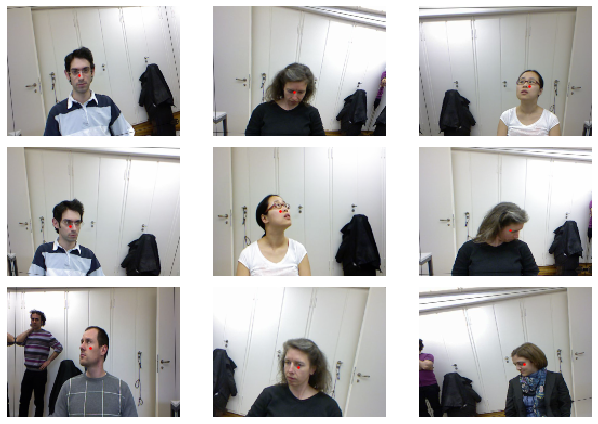

In [13]:
data.show_batch(3, figsize=(9,6))

## Train model

In [ ]:
"""我們創建一個CNN。後面的課程裡我們會學習很多關於損失函數的內容。損失函數是衡量模型效果的函數。
   對於分類問題，我們使用交叉熵（cross-entropy）損失，它代表“你有沒有預測出正確結果，你對這個有多自信？"。
   我們不能用它來做回歸，我們要使用均方差（mean squared error，MSE）。上節課，我們從頭實現了MSE。它就是兩個值的差，做平方，然後加在一起。"""

In [14]:
learn = cnn_learner(data, models.resnet34)
#learn.loss_func = MSELossFlat()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


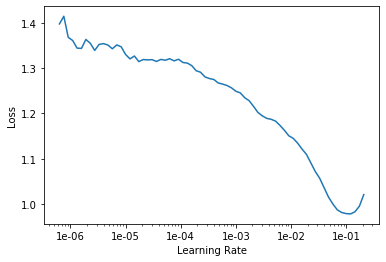

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 2e-2

In [17]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.049797,0.014261,03:56
1,0.017476,0.004171,03:55
2,0.008549,0.003579,03:58
3,0.005328,0.002065,03:54
4,0.004008,0.002309,03:54


In [18]:
learn.save('stage-1')

In [19]:
learn.load('stage-1');

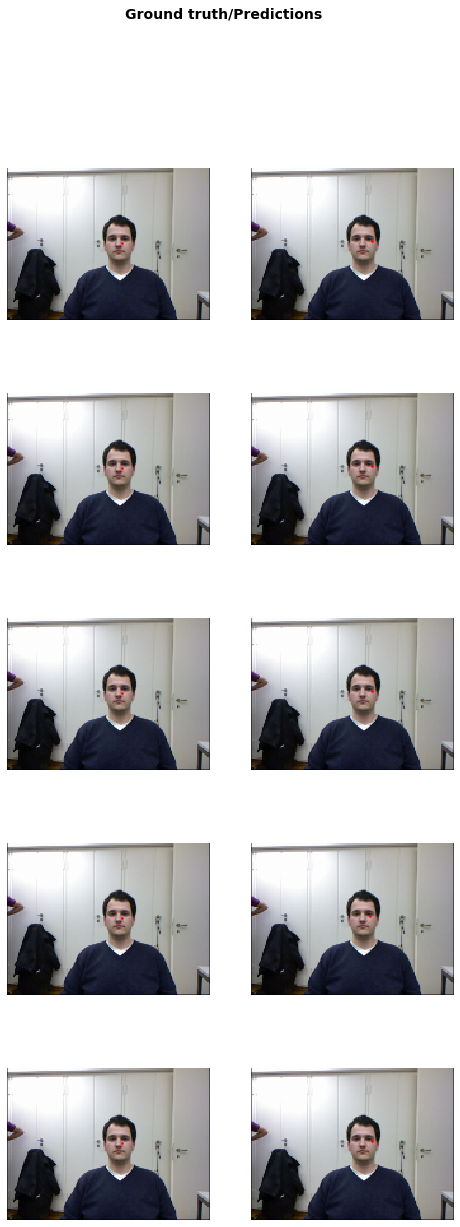

In [20]:
learn.show_results()

## Data augmentation

In [21]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

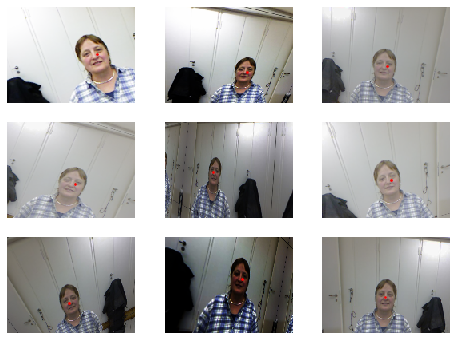

In [22]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))